In [1]:
import os
import time
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import argparse

from vae import VAE
from utils.memory import Memory

import sys
sys.argv=['']

c:\ProgramData\Anaconda3\lib\site-packages\gymnasium\envs\registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\ProgramData\Anaconda3\lib\site-packages\gymnasium\envs\registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
def parse_args():
    parser = argparse.ArgumentParser()

    # ---------- General settings --------- #
    
    parser.add_argument("--gym-env", type=str, default="ALE/MontezumaRevenge-v5")
    parser.add_argument("--seed", type=int, default=1)
    parser.add_argument("--debug", action='store_true')

    parser.add_argument("--n-episodes", type=int, default=1000)
    parser.add_argument("--n-steps", type=int, default=1024)
    parser.add_argument("--save_interval", type=int, default=20)

    # ---------- Vae settings ---------- #

    # Training
    parser.add_argument("--vae-n-epochs", type=int, default=10)
    parser.add_argument("--vae-learning-rate", type=float, default=1e-3)
    parser.add_argument("--vae-batch-size", type=int, default=32)

    # Network setup
    parser.add_argument("--img-size", type=int, default=96)

    args = parser.parse_args()
    return args

In [3]:
args = parse_args()

 # CUDA setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Env setup
env = gym.make(args.gym_env, render_mode = "rgb_array", frameskip = 8)
env = gym.wrappers.ResizeObservation(env, args.img_size)

# Memory setup
memory = Memory(env, args)

# VAE setup
vae = VAE(args)
vae.load("checkpoints/MontezumaRevenge_vae-96_1212_24-04-2023/100.pth")

Using device:  cpu


In [4]:
# Gather data
memory.clear()
state, info = env.reset()
lives = info['lives']
terminated = False

for step in range (0, args.n_steps):

    if terminated:
        memory.append_state(state)

        state, info = env.reset()
        lives = info['lives']
        terminated = False
    
    memory.append_state(state)
    action = env.action_space.sample()

    # Step in environment
    state, _, terminated, _, info = env.step(action)

    # frameskip upon death
    if lives > info['lives']:
        for _ in range (5): env.step(0) # It takes 5 frames to respawn

    lives = info['lives']

# Forward pass
states = memory.get_states()
z_states = vae.encode(states)
r_states = vae.decode(z_states)

In [5]:
def plot(i):
    fig = plt.figure(figsize=(10,5))
    rows = 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    img = np.transpose(states[i].cpu().numpy(), [1,2,0])
    plt.imshow(img)
    plt.title("Original")

    fig.add_subplot(rows, columns, 2)
    r_img_a = np.transpose(r_states[i].detach().numpy(), [1,2,0])
    plt.imshow(np.squeeze(r_img_a))
    plt.title("Model")

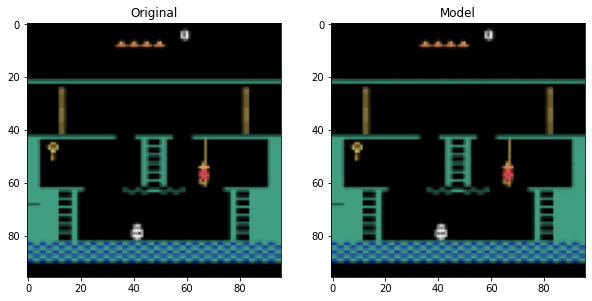

In [20]:
plot(18)